c:\Users\Tristan\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but KMeans was fitted with feature names
  warnings.warn(


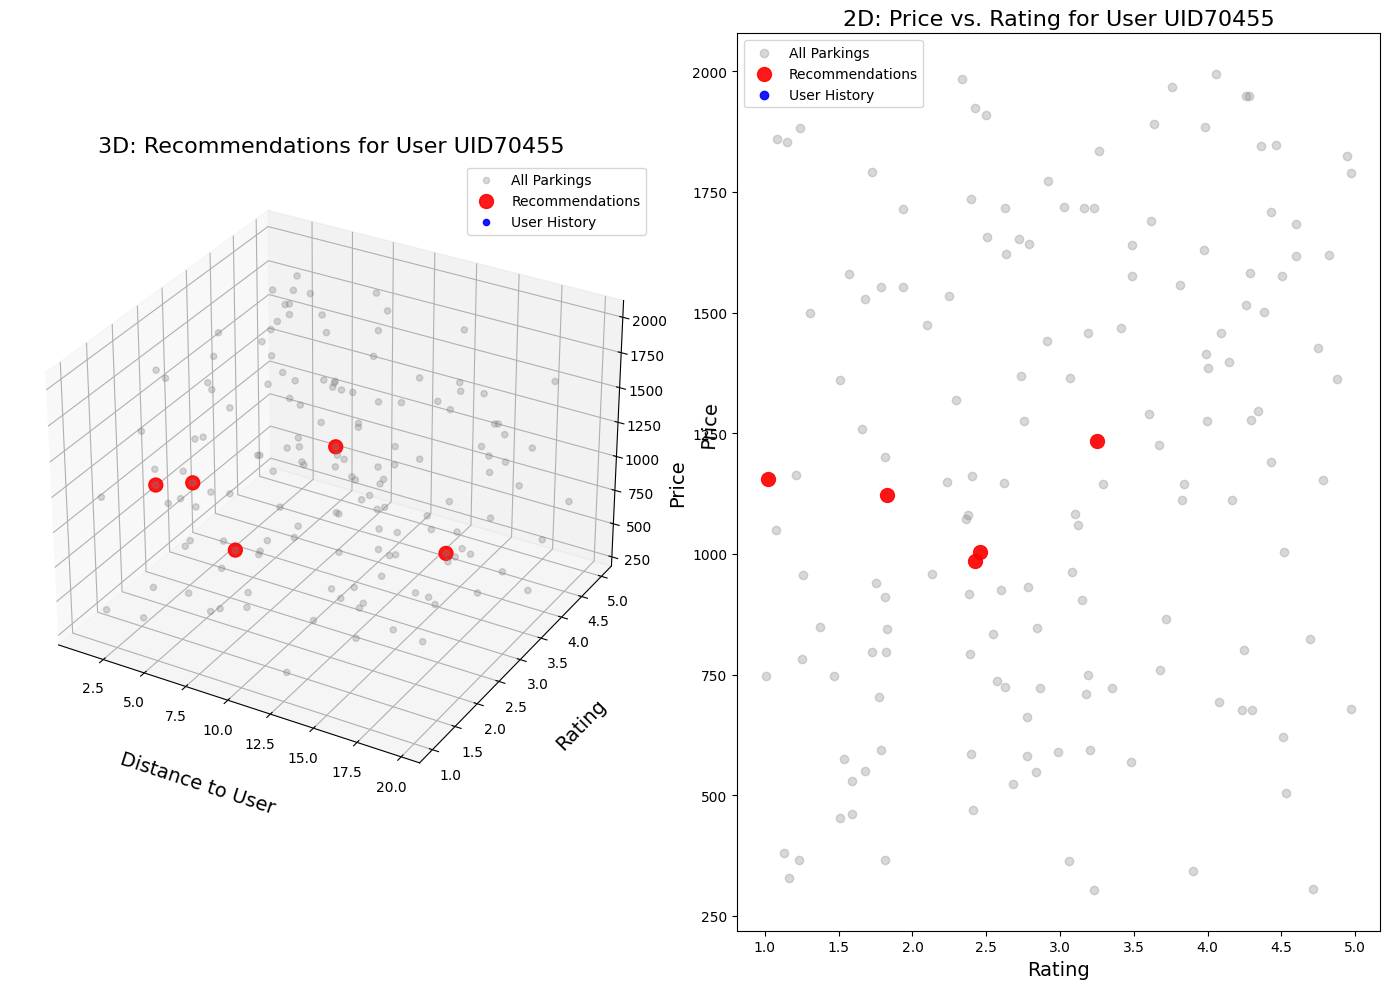

c:\Users\Tristan\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but KMeans was fitted with feature names
  warnings.warn(


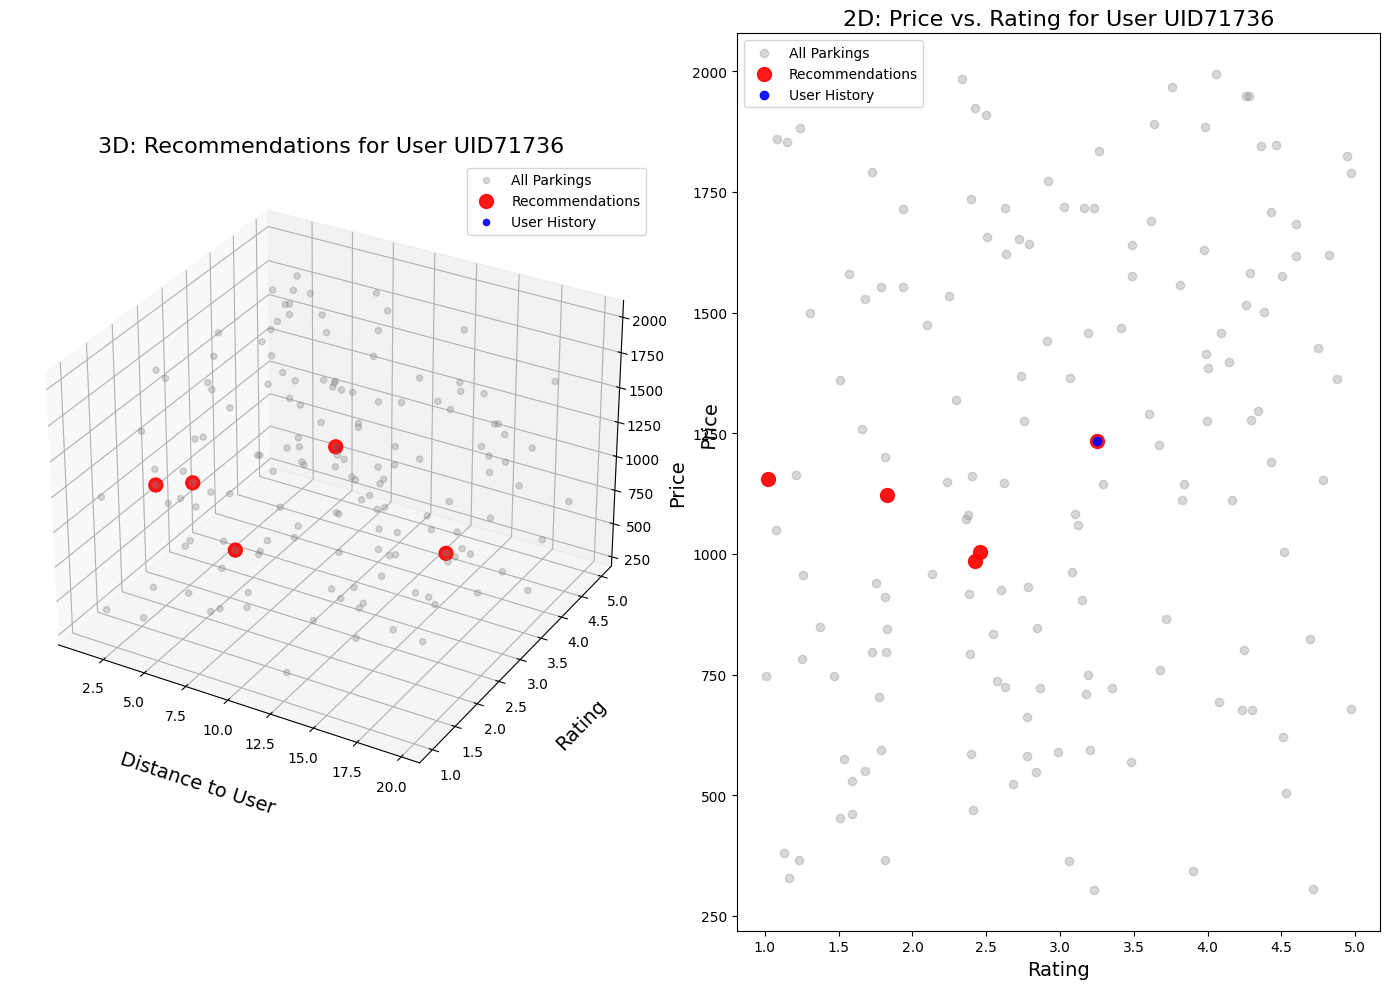

c:\Users\Tristan\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but KMeans was fitted with feature names
  warnings.warn(


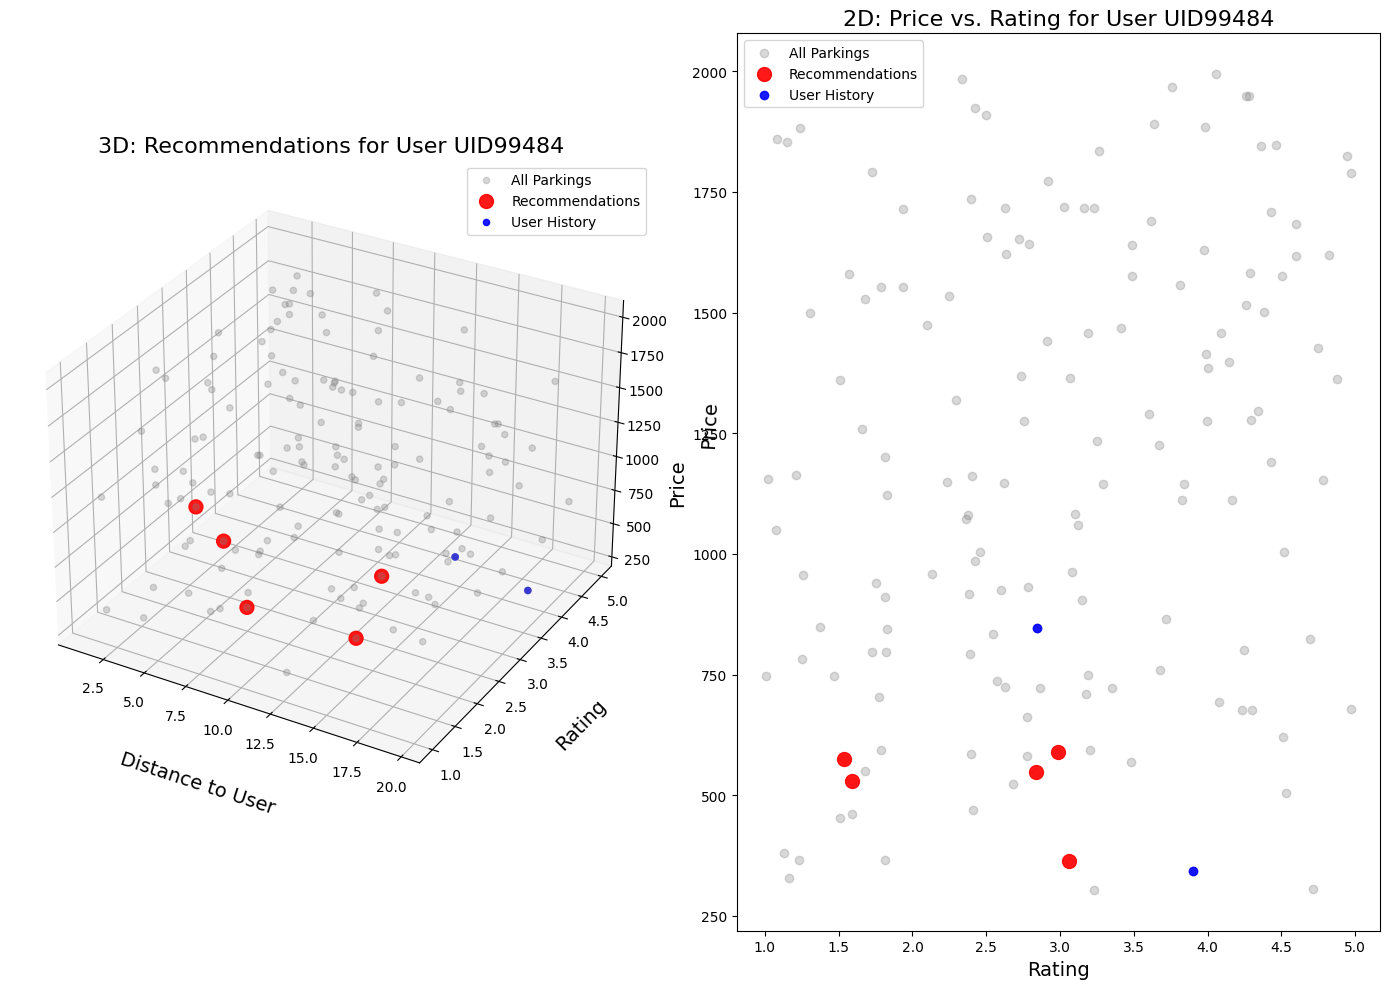

In [24]:
import pandas as pd
from sklearn.cluster import KMeans
import numpy as np
import json
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Ensure Required Columns in Parking Data with Rating
def ensure_required_columns(parking_df):
    required_columns = ['price', 'rating', 'distance']
    for column in required_columns:
        if column not in parking_df.columns:
            if column == 'price':
                parking_df[column] = np.random.uniform(5, 20, size=len(parking_df))
            elif column == 'rating':
                parking_df[column] = np.random.uniform(1.0, 5.0, size=len(parking_df))  # Random ratings from 1 to 5
            elif column == 'distance':
                parking_df[column] = np.random.uniform(1.0, 20.0, size=len(parking_df))
        else:
            # Convert to numeric and handle errors
            parking_df[column] = pd.to_numeric(parking_df[column], errors='coerce')
            parking_df[column].fillna(parking_df[column].mean(), inplace=True)
    return parking_df

private_parking = ensure_required_columns(private_parking)

# K-Means Clustering Algorithm with Rating
def recommend_parking_with_kmeans(user_id, history_df, parking_df, num_clusters=5):
    # Filter user history
    user_history = history_df[history_df["user_id"] == user_id]

    if user_history.empty:
        print(f"No history available for user {user_id}")
        return pd.DataFrame()  # Return an empty DataFrame if no history is available

    # Extract parking features
    parking_features = parking_df[['price', 'rating', 'distance']]
    
    # Train K-Means Model
    kmeans = KMeans(n_clusters=num_clusters, random_state=42, n_init=10)
    parking_df['cluster'] = kmeans.fit_predict(parking_features)

    # Compute user preferences
    avg_price = parking_df.loc[parking_df["private_id"].isin(user_history["parking_id"]), "price"].mean()
    avg_rating = parking_df.loc[parking_df["private_id"].isin(user_history["parking_id"]), "rating"].mean()
    avg_distance = parking_df.loc[parking_df["private_id"].isin(user_history["parking_id"]), "distance"].mean()

    # Replace NaN preferences with column means
    avg_price = avg_price if not pd.isna(avg_price) else parking_features['price'].mean()
    avg_rating = avg_rating if not pd.isna(avg_rating) else parking_features['rating'].mean()
    avg_distance = avg_distance if not pd.isna(avg_distance) else parking_features['distance'].mean()

    user_preferences = np.array([avg_price, avg_rating, avg_distance]).reshape(1, -1)

    # Find nearest cluster to user preferences
    closest_cluster = kmeans.predict(user_preferences)[0]
    
    # Recommend parking spots from the closest cluster
    recommendations = parking_df[parking_df['cluster'] == closest_cluster].head(5)
    return recommendations

from mpl_toolkits.mplot3d import Axes3D

# Visualization for Multiple Users with 3D and 2D Scatter Plots
def visualize_kmeans_recommendations(user_ids, history_df, parking_df):
    for i, user_id in enumerate(user_ids):
        # Get recommendations
        recommendations = recommend_parking_with_kmeans(user_id, history_df, parking_df)
        if recommendations.empty:
            print(f"No recommendations available for user {user_id}")
            continue
        user_history = history_df[history_df["user_id"] == user_id]

        # --- 3D Plot ---
        fig = plt.figure(figsize=(14, 10))
        ax = fig.add_subplot(121, projection='3d')

        # Plot all parkings in 3D
        ax.scatter(parking_df["distance"], parking_df["rating"], parking_df["price"],
                   color="gray", label="All Parkings", alpha=0.3)

        # Highlight recommended parkings in 3D
        if not recommendations.empty:
            ax.scatter(recommendations["distance"], recommendations["rating"], recommendations["price"],
                       color="red", s=100, label="Recommendations", alpha=0.9)

        # Highlight user history in 3D
        if not user_history.empty:
            history_parking = parking_df[parking_df["private_id"].isin(user_history["parking_id"])]
            ax.scatter(history_parking["distance"], history_parking["rating"], history_parking["price"],
                       color="blue", label="User History", alpha=0.9)

        # Set 3D plot labels with larger font
        ax.set_title(f"3D: Recommendations for User {user_id}", fontsize=16)
        ax.set_xlabel("Distance to User", labelpad=20, fontsize=14)
        ax.set_ylabel("Rating", labelpad=20, fontsize=14)
        ax.set_zlabel("Price", labelpad=20, fontsize=14)
        ax.legend()

        # --- 2D Plot (Price vs. Rating) ---
        ax2 = fig.add_subplot(122)

        # Plot all parkings in 2D
        ax2.scatter(parking_df["rating"], parking_df["price"], color="gray", label="All Parkings", alpha=0.3)

        # Highlight recommended parkings in 2D
        if not recommendations.empty:
            ax2.scatter(recommendations["rating"], recommendations["price"], color="red", s=100, label="Recommendations", alpha=0.9)

        # Highlight user history in 2D
        if not user_history.empty:
            history_parking = parking_df[parking_df["private_id"].isin(user_history["parking_id"])]
            ax2.scatter(history_parking["rating"], history_parking["price"], color="blue", label="User History", alpha=0.9)

        # Set 2D plot labels with larger font
        ax2.set_title(f"2D: Price vs. Rating for User {user_id}", fontsize=16)
        ax2.set_xlabel("Rating", fontsize=14)
        ax2.set_ylabel("Price", fontsize=14)
        ax2.legend()

        # Show the plots
        plt.tight_layout()
        plt.show()

# Test K-Means Recommendations with Both Visualizations
user_ids_to_test = ["UID70455", "UID71736", "UID99484"]  # Specified users
visualize_kmeans_recommendations(user_ids_to_test, history, private_parking)
